In [219]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.applications import ResNet50
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ReduceLROnPlateau


In [96]:
print(os.listdir("data"))
dataset = []
labels = []

['sample_submission.csv', 'test.csv', 'test_images', 'train.csv', 'train_images']


In [97]:
def prepare_Images(label,path):
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img_res=cv2.resize(img,(50,50))
    img_array = img_to_array(img_res)
    img_array = img_array/255
    dataset.append(img_array)
    labels.append(str(label))

In [98]:
train_Data = pd.read_csv("data/train.csv")
train_Data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [99]:
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

In [100]:
for id_code,diagnosis in tqdm(zip(id_code_Data,diagnosis_Data)):
    path = os.path.join('data/train_images','{}.png'.format(id_code))
    prepare_Images(diagnosis,path)

3662it [03:43, 16.42it/s]


In [199]:
#Convert list to numpy array
images = np.array(dataset)
label_arr = np.array(labels)

In [200]:
#spliting the training data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(images,label_arr,test_size=0.20,random_state=42)

In [201]:
#Convert to class labels categorical
y_train = np_utils.to_categorical(y_train, num_classes=5)
y_test = np_utils.to_categorical(y_test, num_classes=5)

In [260]:
# Building model
model=Sequential()

model.add(Conv2D(filters=1024,kernel_size=2,padding="same",activation="relu",input_shape=(50,50,3)))
model.add(AveragePooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu"))
model.add(AveragePooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=1024,kernel_size=2,padding="same",activation="relu"))
model.add(AveragePooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu"))
model.add(AveragePooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(Conv2D(filters=512,kernel_size=2,padding="same",activation="relu"))
# model.add(AveragePooling2D(pool_size=2))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Conv2D(filters=256,kernel_size=2,padding="same",activation="relu"))
model.add(AveragePooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(5,activation="softmax"))

model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_272 (Conv2D)          (None, 50, 50, 1024)      13312     
_________________________________________________________________
average_pooling2d_45 (Averag (None, 25, 25, 1024)      0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 25, 25, 1024)      4096      
_________________________________________________________________
dropout_146 (Dropout)        (None, 25, 25, 1024)      0         
_________________________________________________________________
conv2d_273 (Conv2D)          (None, 25, 25, 512)       2097664   
_________________________________________________________________
average_pooling2d_46 (Averag (None, 12, 12, 512)       0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 12, 12, 512)     

In [261]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [262]:
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

Epoch 1/1
2929/2929 [==============================] - 24s 8ms/step - loss: 3.0315 - accuracy: 0.4510


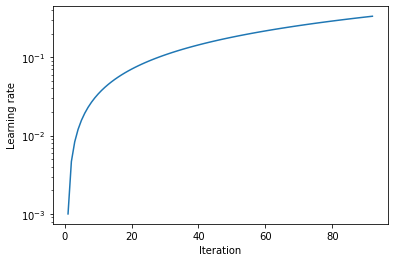

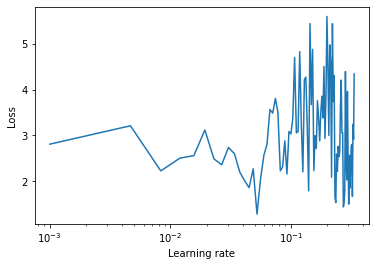

In [263]:
lr_finder = LRFinder(min_lr=0.001, 
                                 max_lr=0.1, 
                                 steps_per_epoch=9, 
                                 epochs=3)
model.fit(x_train, y_train, callbacks=[lr_finder])
lr_finder.plot_lr()
lr_finder.plot_loss()

In [264]:
opt = keras.optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
Callbacks=[EarlyStopping(patience=16, restore_best_weights=True), 
           ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=True)]

In [265]:
history = model.fit(x_train,y_train,batch_size=32,epochs=50,verbose=1,callbacks=Callbacks,validation_data=(x_test, y_test))

Train on 2929 samples, validate on 733 samples
Epoch 1/50
2929/2929 [==============================] - 24s 8ms/step - loss: 2.4645 - accuracy: 0.5278 - val_loss: 7.3112 - val_accuracy: 0.2906
Epoch 2/50
2929/2929 [==============================] - 23s 8ms/step - loss: 1.8774 - accuracy: 0.5538 - val_loss: 2.5814 - val_accuracy: 0.4789
Epoch 3/50
2929/2929 [==============================] - 23s 8ms/step - loss: 1.5031 - accuracy: 0.5828 - val_loss: 2.3755 - val_accuracy: 0.3424
Epoch 4/50
2929/2929 [==============================] - 23s 8ms/step - loss: 1.4416 - accuracy: 0.5941 - val_loss: 2.5350 - val_accuracy: 0.2046
Epoch 5/50
2929/2929 [==============================] - 23s 8ms/step - loss: 1.2855 - accuracy: 0.6019 - val_loss: 1.6773 - val_accuracy: 0.4025
Epoch 6/50
2929/2929 [==============================] - 23s 8ms/step - loss: 1.1846 - accuracy: 0.6210 - val_loss: 0.9679 - val_accuracy: 0.6003
Epoch 7/50
2929/2929 [==============================] - 23s 8ms/step - loss: 1.1622

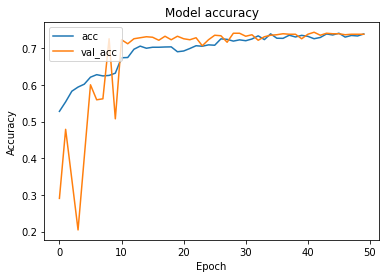

In [266]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.show()

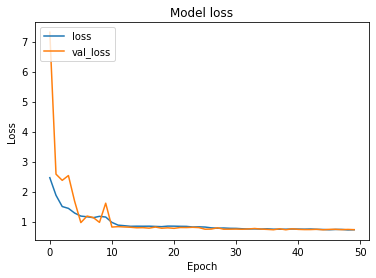

In [267]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [268]:
model.save("model_scratch.h5")

In [269]:
pred = model.predict(x_test)

In [270]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
score = round(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(score)

0.74


In [271]:
k_score = round(cohen_kappa_score(y_test.argmax(axis=1), pred.argmax(axis=1)),2)
print(k_score)

0.58


In [272]:
report = classification_report(y_test.argmax(axis=1), pred.argmax(axis=1))
print(report)

precision    recall  f1-score   support

           0       0.90      0.98      0.93       351
           1       0.43      0.26      0.33        68
           2       0.58      0.84      0.69       213
           3       0.67      0.06      0.10        36
           4       0.00      0.00      0.00        65

    accuracy                           0.74       733
   macro avg       0.51      0.43      0.41       733
weighted avg       0.67      0.74      0.68       733



In [276]:
conMat = confusion_matrix(y_test.argmax(axis=1),pred.argmax(axis=1))
print(conMat)

[[343   2   6   0   0]
 [ 11  18  38   1   0]
 [ 17  18 178   0   0]
 [  3   1  30   2   0]
 [  9   3  53   0   0]]


In [277]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [278]:
x = test_df['id_code']
test_Dataset = []

In [279]:
def make_test_data(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img_res = cv2.resize(img, (50,50))
    img_array = img_to_array(img_res)
    img_array = img_array/255
    test_Dataset.append(img_array)

In [245]:
for id_code in tqdm(x):
    path = os.path.join('data/test_images','{}.png'.format(id_code))
    make_test_data(path)
test_images = np.array(test_Dataset)
pred=model.predict(test_images)
pred=np.argmax(pred,axis=1)
pred

100%|██████████| 1928/1928 [00:43<00:00, 44.55it/s]


array([2, 2, 2, ..., 2, 2, 0], dtype=int64)

In [246]:
pred.shape

(1928,)

In [247]:
test_images.shape

(1928, 50, 50, 3)

In [248]:
sub_df = pd.read_csv('data/sample_submission.csv')
sub_df.head()

sub_df.diagnosis = pred
sub_df.head()

sub_df.to_csv("submission.csv",index=False)